# Taller de Descriptores I

In [54]:
# Imports 
from skimage import io
import os
from os.path import join
import numpy as np
from skimage.color import label2rgb, rgb2gray
from skimage import feature
from skimage import img_as_ubyte
from skimage.measure import label, find_contours, moments_central, moments_normalized, moments_hu
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from skimage.measure import regionprops, regionprops_table
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import plotly.express as px
from scipy.stats import skew, kurtosis, entropy

In [55]:
import skimage
skimage.__version__

'0.17.2'

## Algunas funciones y modulos interesantes

Usaremos para extraer "algunos descriptores" algunos módulos de `scikit-image`. Uno de los más frecuentes será `skimage.measure`, donde encontraremos implementaciones de conectar regiones (`label`), encontrar contornos (`find_contours`), encontrar diversos descriptores geométricos (`regionprops`, y `regionprops_table`), diferentes momentos (`moments`, `moments_central`, `moments_coords`, etc.), entre otros.  

Otro módulo relacionado con extracción de características es `skimage.feature`, el cuál tiene muchos descriptores (más alla de lo que hemos visto y otros que veremos). Especialmente, usaremos `greycomatrix` y `greycoprops`. 

## Imagen con figuras simples para practicar
Usaremos una imagen con figuras simples para extraer algunos descriptores geométricos.  Cargue la imagen de `Simple-figures.png`

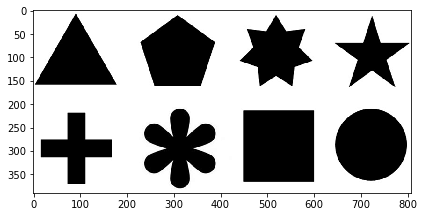

In [56]:
DIR = "images" 
I = io.imread(join(DIR, "Simple-figures.png"))
io.imshow(I);

Realice una segmentación básica para obtener una máscara como muestra la siguiente figura (blanco figuras, negro fondo):

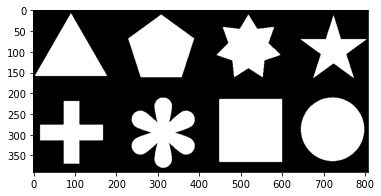

In [57]:
seg = I < 100
plt.imshow(seg, cmap = 'gray')

### (1)  Implemente algunos descriptores básicos

- Calcule el área de cada objeto (podría encontrar útil usar `skimage.measure.label` para separar las regiones)
- Encuentre el contorno de cada objeto usando `find_contours`.
- A partir del contorno determine el perímetro de cada objeto, el diámetro equivalente (o longitud el eje mayor) y la longitud del eje menor. Con esto determine la excentricidad.

In [58]:
etiquetas = label(seg)
area = []
for i in range(1,9):
    aux = np.sum(etiquetas == i)
    area.append(aux)
area

[13289, 16676, 12056, 8007, 18388, 14823, 23101, 10071]

In [59]:
perimetros = []
for i in range(1,9):
    contornos = find_contours(etiquetas == i, level=0.5)
    y,x = contornos[0].T
    dist = np.sqrt(np.diff(x)**2 + np.diff(y)**2)
    perimetros.append(np.sum(dist))
perimetros

[546.0731598529186,
 516.9015869776648,
 596.8843430349618,
 633.4701294725887,
 507.38686835190333,
 907.619407771256,
 605.0710678118655,
 600.727922061358]

In [60]:
diametros = []
for i in range(1,9):
    contornos = find_contours(etiquetas == i, level=0.5)
    y,x = contornos[0].T
    aux = np.array([x,y]).T
    mt_dist = distance_matrix(aux,aux)
    diametros.append(mt_dist.max())
diametros

[173.7728402253931,
 159.26079241294764,
 154.7804897265802,
 158.75137794677562,
 154.20765220960988,
 169.95587662684687,
 213.55093069335942,
 156.43848631331102]

### (2) Calcule algunos descriptores geométricos usando  `skimage.measure.regionprops`
- Explore los descriptores que genera `regionprops` (también genera imágenes, como el convex hull). 
- A partir de esta función, utilice todos los descriptores geométricos que pueda (no imágenes) y genere una tabla de descriptores (un data frame de pandas) con una columna adicional de etiqueta para cada objeto (podría deducirlo a partir del centroide).
- ¿Puede diferenciar cada objeto a partir de los descriptores? 
- Visualice los resultados graficando diagramas de dispersión y boxplots de los descriptores.
- Grafique las dos primeras componentes principales de los descriptores para cada objeto. ¿Se logra diferenciar los objetos?

In [61]:
descriptores_rgp = regionprops_table(etiquetas, properties=["label", "area","eccentricity",
                                                            "centroid", "perimeter", "major_axis_length",
                                                           "minor_axis_length"])

In [62]:
label_to_figure = {1: "Triangulo", 2:"Pentagono", 3:"Bomba", 4:"Estrella", 5:"Circulo",
                   6:"Cuadrado", 7:"Trebol", 8:"Suma"}

In [63]:
df = pd.DataFrame(descriptores_rgp)
df.head()

,label,area,eccentricity,centroid-0,centroid-1,perimeter,major_axis_length,minor_axis_length
0,1,13289,0.016790,107.927835,91.055158,543.244733,143.029384,143.009222
1,2,16676,0.074791,93.877069,308.729671,514.073160,147.155453,146.743310
2,3,12056,0.034460,89.868033,519.204877,593.227489,128.714364,128.637918
3,4,8007,0.119711,95.902460,724.436118,626.813275,118.129484,117.279986
4,5,18388,0.077168,286.645095,722.099521,504.558441,153.239660,152.782711


In [64]:
df["label"] = df["label"].apply(label_to_figure.get)

In [65]:
df

,label,area,eccentricity,centroid-0,centroid-1,perimeter,major_axis_length,minor_axis_length
0,Triangulo,13289,0.016790,107.927835,91.055158,543.244733,143.029384,143.009222
1,Pentagono,16676,0.074791,93.877069,308.729671,514.073160,147.155453,146.743310
2,Bomba,12056,0.034460,89.868033,519.204877,593.227489,128.714364,128.637918
3,Estrella,8007,0.119711,95.902460,724.436118,626.813275,118.129484,117.279986
4,Circulo,18388,0.077168,286.645095,722.099521,504.558441,153.239660,152.782711
5,Cuadrado,14823,0.045842,294.687580,313.567564,904.790981,152.342233,152.182077
6,Trebol,23101,0.016011,289.503268,524.503268,602.242641,175.499584,175.477087
7,Suma,10071,0.133580,294.209413,92.492503,597.899495,135.939188,134.720904


<function matplotlib.pyplot.show(close=None, block=None)>

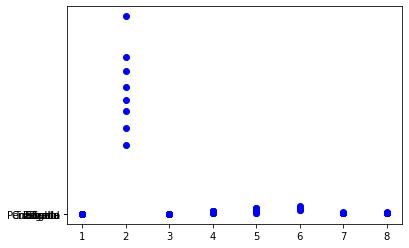

In [66]:
for col in range(8):
    plt.scatter([col+1]*len(df), df.iloc[:, col], color="b")
plt.show

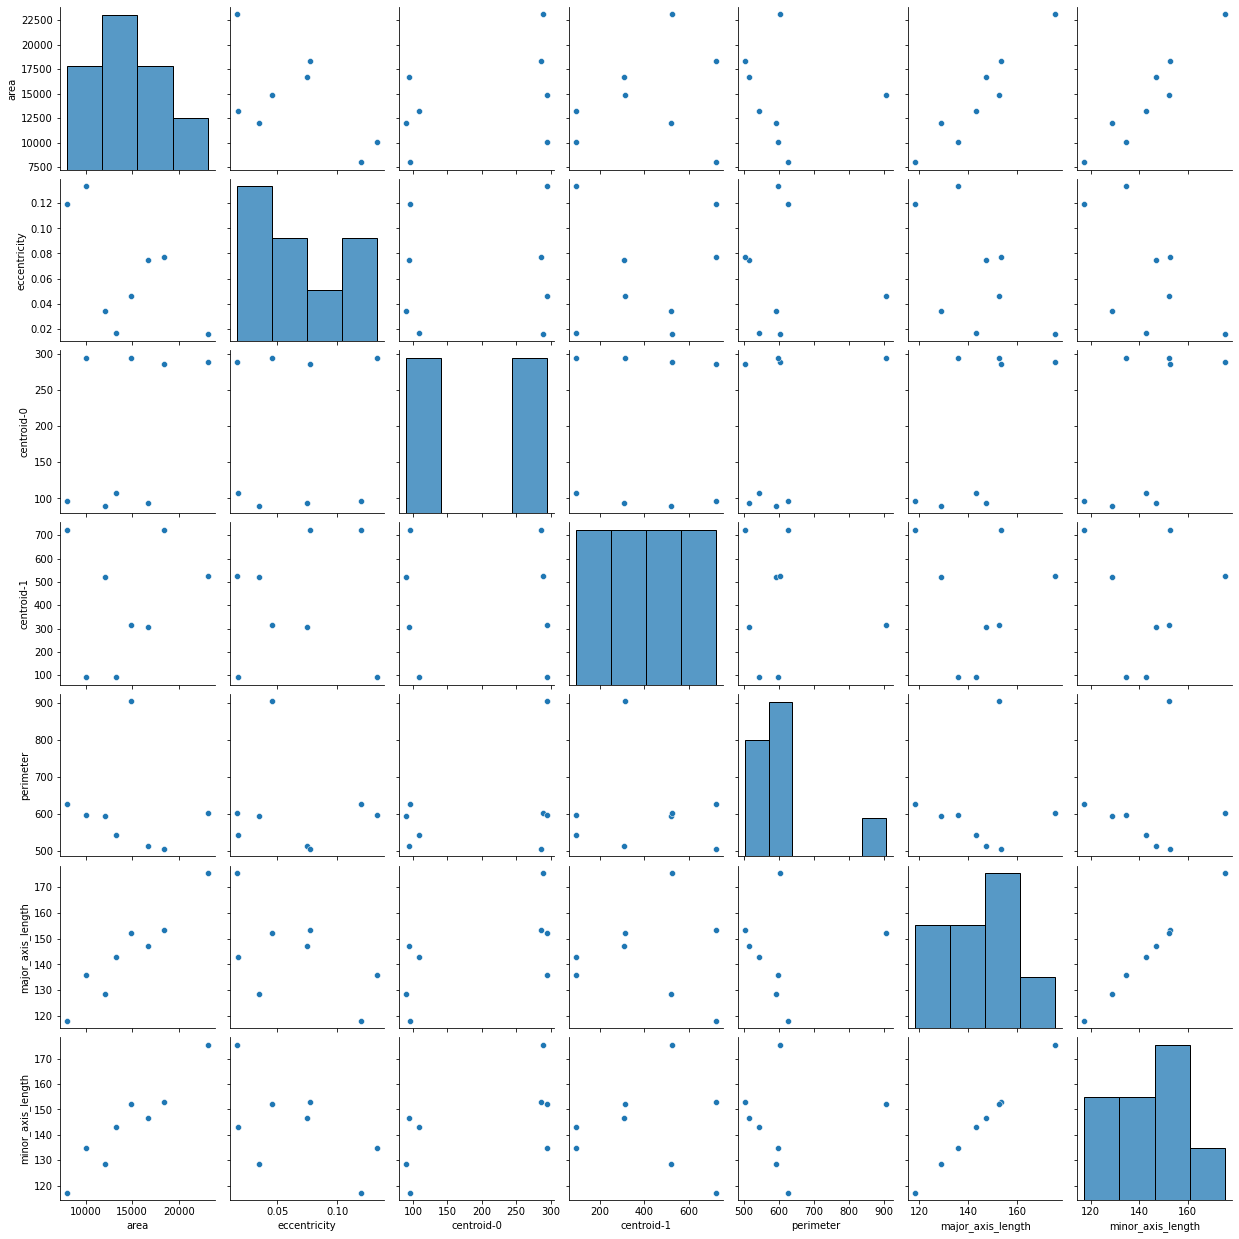

In [67]:
sns.pairplot(df)

<AxesSubplot:>

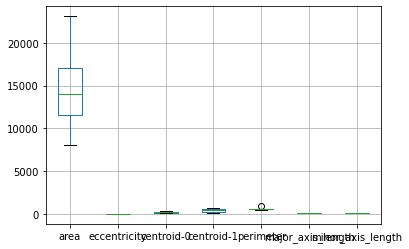

In [68]:
df.boxplot()

In [69]:
pca = PCA(n_components=2)
features = [ "area","eccentricity","centroid-0","centroid-1", "perimeter", 
            "major_axis_length","minor_axis_length"]

pca = PCA()
components = pca.fit_transform(df[features])
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(4),
    color=df["label"]
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [70]:
pca.explained_variance_

array([2.33085014e+07, 6.19311995e+04, 1.84938050e+04, 5.72200899e+03,
       6.58200652e+00, 2.52908736e-02, 2.08179554e-05])

## Más descriptores (estadísticos)

Para esta parte usaremos las imágenes que se encuentran en `images/textures`. Son 10 imágenes de diferentes materiales. Para simplificar el problema, convierta las imágenes a escala de grises.

### (3) Calcule algunos descriptores estadísticos de primer orden 

- Calcule para cada imagen (a partir del histograma) descriptores estadísticos básicos como: media, desviación estándar, skewness, curtósis, máximo, mínimo, contraste, uniformidad, entropía (ver diapositiva 64). 

- Calcule para cada imagen los momentos centrales invariantes. Le será útil `skimage.measure.moments_hu` (vea el ejemplo de la documentación en este [link](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.moments_hu) ).

- Para cada imagen calcule la matriz de co-ocurrencia (para cero grados) y grafiquelas en una sóla figura (etiquetando el tipo de textura).

- Calcule para cada imagen la matriz de co-ocurrencia de las 4 direcciones de 0, 45, 90 y 135 grados de forma simétrica y con una distancia de un pixel. A partir de estas matrices determine los descriptores de contraste, disimilaridad, homogeneidad, ASM, energía y correlación. Los descriptores finales, son el promedio de cada descriptor en las 4 direcciones (por ejemplo, contraste = mean(contraste_0,contraste_45,contraste_90,contraste_135) ).

- **opcional**. Calcule para cada imagen los descriptores de textura generados por `skimage.feature.multiscale_basic_features`.

- Genere una tabla (data frame) en donde se concatenen los descriptores determinados anteriormente. En donde cada fila es una imagen y cada columna es un descriptor. La tabla debe tener una columna de etiquetas.

- Es mucho más complejo visualizar todos los descriptores. Use PCA  o la técnica de T-SNE (ambas se encuentran es scikit-learn) para realizar una visualización bidimensional de cada imagen.

Sugerencia1 : al final cree una función en donde la entrada sea una imagen y la salida el conjunto de descriptores.

Sugerencia2: Para calcular la matriz de coocurrencia es importante convertir la imagen a un formato de 8 bits. un ejemplo de como calcular las matrices (observe que G contiene las 4 matrices) es

`G = feature.greycomatrix(img_as_ubyte(I),[1],[0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True)`

### Lectura de imagenes y transformación a escala de grises

In [71]:
imgs = []
DIR = 'images/textures'
texture_files = os.listdir(DIR)
for i in range(len(texture_files)):
    imgs.append(io.imread(join(DIR, texture_files[i])))
# Pasando imagenes a grises
imgs = [rgb2gray(im) for im in imgs]

### 1. Consiguiendo descriptores estadisticos

In [72]:
#media,desviación estándar, skewness, curtósis, máximo, mínimo, contraste, uniformidad, entropía (ver diapositiva 64)
n_col = 9
mat = np.zeros([len(imgs),n_col])

for i in range(len(imgs)):
    hist_data = np.histogram(imgs[i],bins=np.arange(256))
    I = (imgs[i]*255).round()
    p = dict()
    uniformity = 0
    for j in range(256):
        p[j] = np.count_nonzero(I == j)/(I.shape[0]*I.shape[1])
        uniformity +=p[j]**2
    mat[i,0] = imgs[i].mean() # media
    mat[i,1] = imgs[i].std() # desviacion estandar
    mat[i,2] = skew(imgs[i].reshape(imgs[i].shape[0]*imgs[i].shape[1])) # skewness
    mat[i,3] = kurtosis(imgs[i].reshape(imgs[i].shape[0]*imgs[i].shape[1]))
    mat[i,4] = imgs[i].min() # minimo
    mat[i,5] = imgs[i].max() # maximo
    mat[i,6] = 1.0 - (1.0/(1+ imgs[i].std()**2)) # contraste
    # Uniformidad  y entropia con histogramas
    mat[i,7] = uniformity #uniformidad
    mat[i,8] = entropy([p[k] for k in p.keys()]) # entropia
    
df = pd.DataFrame(mat,columns=["media","desviacion estándar", "skewness", "curtosis", "maximo",
                               "minimo", "contraste", "uniformidad", "entropia"])

In [73]:
df

,media,desviacion estándar,skewness,curtosis,maximo,minimo,contraste,uniformidad,entropia
0,0.607370,0.233672,-0.020923,-1.206617,0.088756,1.0,0.051776,0.004918,5.346776
1,0.715518,0.115860,0.344999,-0.884062,0.382689,1.0,0.013246,0.009988,4.702008
2,0.619006,0.218438,0.006449,-0.876501,0.207157,1.0,0.045542,0.008743,5.024802
3,0.604609,0.227522,0.412998,-1.157831,0.255743,1.0,0.049218,0.007737,5.065493
4,0.613957,0.209896,0.640552,-0.951591,0.347613,1.0,0.042197,0.016907,4.655934
5,0.616007,0.226848,-0.630436,0.134971,0.004182,1.0,0.048941,0.005690,5.292681
6,0.608595,0.221339,0.294060,-1.175526,0.250934,1.0,0.046703,0.006667,5.131544
7,0.621429,0.233165,-0.815892,-0.044673,0.017500,1.0,0.051563,0.005594,5.333744
8,0.632057,0.201694,0.086575,-0.620217,0.130293,1.0,0.039090,0.006095,5.215745
9,0.616299,0.221962,0.053633,-0.937539,0.005833,1.0,0.046954,0.005685,5.297676


### 2. Momentos

In [74]:
# Por que son 7 momentos?
mat_moments = np.zeros([len(imgs),7])
for i in range(len(imgs)):
    mu = moments_central(imgs[i])
    nu = moments_normalized(mu)
    mat_moments[i,:] = moments_hu(nu)
    
moments = pd.DataFrame(mat_moments, columns = ["Momento "+str(i) for i in range(1,8)])
moments

,Momento 1,Momento 2,Momento 3,Momento 4,Momento 5,Momento 6,Momento 7
0,0.272862,0.004109,0.000033,0.000004,-1.050053e-11,3.233690e-08,4.186185e-11
1,0.238479,0.004105,0.000008,0.000002,6.131272e-12,-1.107572e-07,-2.435171e-12
2,0.294787,0.009756,0.000006,0.000135,-9.699502e-10,1.287261e-05,-3.792131e-09
3,0.268841,0.003730,0.000797,0.000878,7.207339e-07,4.936007e-05,1.400058e-07
4,0.280659,0.005649,0.000024,0.000026,-4.771244e-10,2.751400e-07,4.415473e-10
5,0.247930,0.002599,0.000085,0.000048,3.072248e-09,2.297826e-06,5.237222e-10
6,0.273383,0.005315,0.000426,0.000392,5.609443e-08,2.077847e-05,-1.496346e-07
7,0.273261,0.005026,0.000089,0.000005,2.972446e-11,3.134198e-07,9.315619e-11
8,0.262436,0.005775,0.000048,0.000045,-1.468604e-09,1.879924e-06,-1.516074e-09
9,0.260270,0.003455,0.000153,0.000010,-3.758013e-10,-5.742236e-07,8.004517e-11


### 3. Matriz de co-ocurrencia (0 grados)

In [75]:
# realizar matrices de co ocurrencia en funcion
cooc_matrices = []
for i in range(len(imgs)):
    I = (imgs[i]*255).round().astype(int)
    coocc = I.T.dot(I)
    cooc_matrices.append(coocc)

In [92]:
I.shape

(384, 512)

In [76]:
from copy import deepcopy

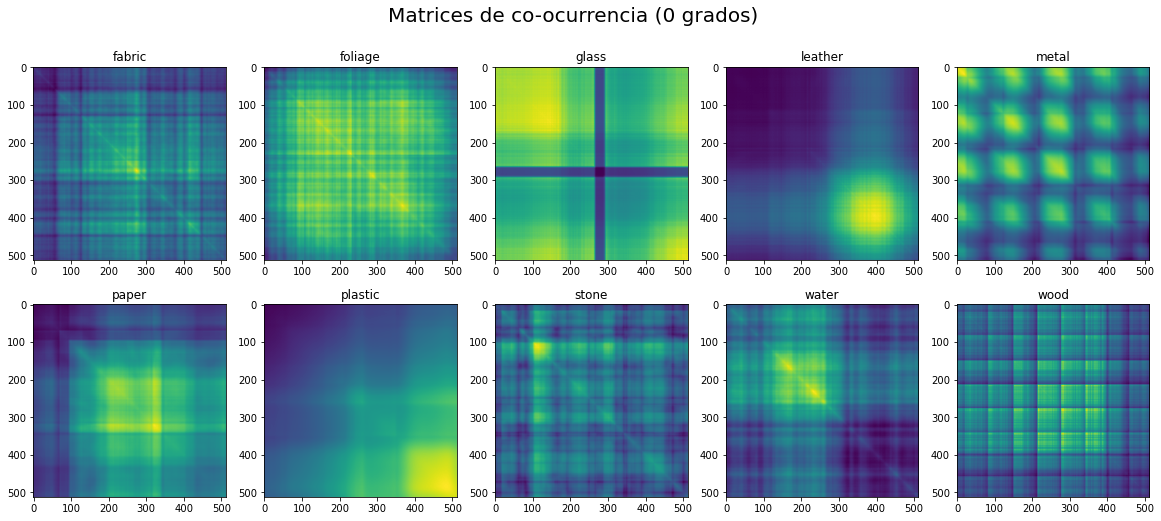

In [91]:
texturas = ["fabric", "foliage", "glass", "leather", "metal", "paper", "plastic", "stone", "water", "wood"]
fig, axs = plt.subplots(2,5,figsize=(20,8))
fig.suptitle('Matrices de co-ocurrencia (0 grados)', fontsize=20)
for j in range(5):
    axs[0,j].imshow(cooc_matrices[j])
    axs[0,j].set_title(texturas[j])
    #axs[0,j].axis("off")
    
for j in range(5):
    axs[1,j].imshow(cooc_matrices[5+j])
    axs[1,j].set_title(texturas[5+j])
    #axs[1,j].axis("off")


In [82]:
texturas

['fabric',
 'foliage',
 'glass',
 'leather',
 'metal',
 'paper',
 'plastic',
 'stone',
 'water',
 'wood']

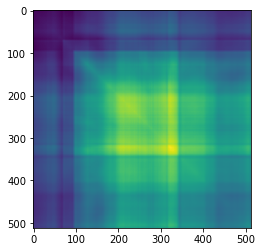

In [46]:
plt.imshow(cooc_matrices[5])

In [77]:
texture_files

['fabric.jpg',
 'foliage.jpg',
 'glass.jpg',
 'leather.jpg',
 'metal.jpg',
 'paper.jpg',
 'plastic.jpg',
 'stone.jpg',
 'water.jpg',
 'wood.jpg']

## Reconocimiento automático usando machine learning

Las imágenes anteriores son una muestra de una dataset mucho mayor que se encuentra en el archivo `FMD.zip` (Este dataset se puede bajar directamente en este [link](https://people.csail.mit.edu/celiu/CVPR2010/FMD/FMD.zip) ). El cuál contiene en la sub-carpeta de `image` (no usar las máscaras de la carpeta `mask`) 10 tipos diferentes de imágenes (organizadas por sub-carpetas). 

### (4) Generando un dataset de descriptores y clasificando.
- Repita el punto (3) sobre todo el dataset de imágenes, generando una tabla de descriptores donde cada fila es una imagen y cada columna los descriptores. Esta tabla debe tener una columna de etiquetas (extraida de los nombres de las carpetas). 
- Con este dataset, divida en un training y test sets, y realice una clasificación (evaluando sobre el test set, accuracy, matriz de confusión, etc.) utilizando un método de clasificación cómo Random Forest (de scikit-learn, puede usar otros métodos).  Recuerde que puede depurar el proceso de machine learning usando selection de features, PCA, búsqueda de hiperparámetros, etc (sin embargo, para el taller, no se complique demasiado si obtiene buenos resultados desde el inicio).
